In [ ]:
!sudo apt-get install libkrb5-dev -q

In [ ]:
!pip install arcgis==1.8.4 torch==1.4.0 fastai==1.0.60 torchvision==0.5.0 -q

### 1. Necessary imports

In [5]:
import os
import pandas as pd
from pathlib import Path

from arcgis.learn import RetinaNet, prepare_data

In [6]:
!ls

sample_data


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Prepare data that will be used for training

### 3. Model Training

In [11]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [12]:
filepath = '/content/drive/MyDrive/vehicle_detection_and_tracking.zip'

In [13]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [14]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [15]:
data = prepare_data(data_path, 
                    batch_size=4, 
                    dataset_type="PASCAL_VOC_rectangles", 
                    chip_size=480)

In [16]:
data.classes

['background',
 'bicycle',
 'bus',
 'car',
 'motorcycle',
 'person',
 'scooter',
 'tempo',
 'tractor',
 'truck',
 'van']

### 4. Visualize training data

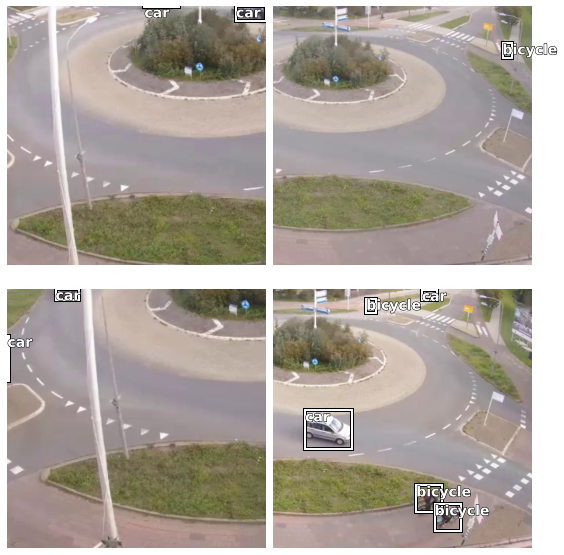

In [17]:
data.show_batch()

### 5. Load model architecture

In [18]:
retinanet = RetinaNet(data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

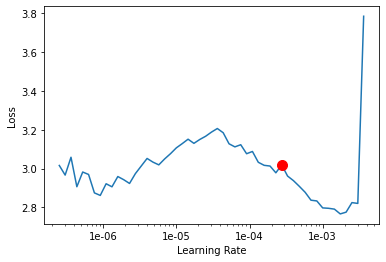

In [19]:
lr = retinanet.lr_find()

### 6. Train the model

In [20]:
retinanet.fit(100, lr=lr, tensorboard=True)

/usr/local/lib/python3.7/dist-packages/arcgis/learn/models/_arcgis_model.py:705: UserWarning: Install tensorboardX 2.1 'pip install tensorboardx==2.1' to write training log
  warn("Install tensorboardX 2.1 'pip install tensorboardx==2.1' to write training log")


epoch,train_loss,valid_loss,time
0,2.858976,3.455671,00:17
1,2.589504,2.660795,00:16
2,2.107145,3.451891,00:17
3,1.739812,3.031165,00:17
4,1.473551,5.781496,00:17
5,1.346004,2.778266,00:17
6,1.235703,2.599452,00:17
7,1.231781,1.606060,00:17
8,1.069589,1.406435,00:20
9,1.032852,1.522913,00:17


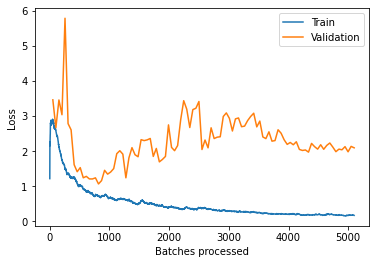

In [21]:
retinanet.learn.recorder.plot_losses()

### 7. Visualize results on validation set

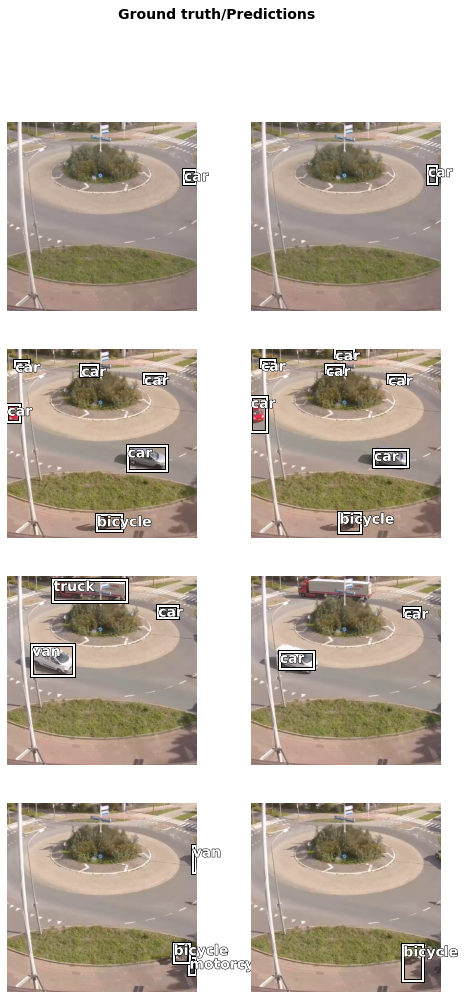

In [22]:
retinanet.show_results(thresh=0.4)

In [23]:
retinanet.average_precision_score(detect_thresh=0.4)

{'bicycle': 0.5374999826153122,
 'bus': 0.0,
 'car': 0.8305568673103916,
 'motorcycle': 0.0,
 'person': 0.0,
 'scooter': 0.0,
 'tempo': 0.0,
 'tractor': 0.0,
 'truck': 0.5,
 'van': 0.09090909361839294}

In [24]:
all_classes=[]
for i, bb in enumerate(data.train_ds.y):
    all_classes += bb.data[1].tolist()
    
df = pd.value_counts(all_classes, sort=False)
df.index = [data.classes[i] for i in df.index] 
df

car           747
van            75
bicycle       267
person         26
scooter         7
motorcycle     32
truck          29
bus            23
tempo           1
tractor         3
dtype: int64

### 8. Save the model

In [25]:
retinanet.save('vehicle_det_ep100_defaults')

Computing model metrics...


PosixPath('/content/drive/MyDrive/vehicle_detection_and_tracking/models/vehicle_det_ep100_defaults')

### 9. Inference and tracking

In [31]:
videopath = '/content/vehicle_detection_and_tracking_video.zip'

In [32]:
import zipfile
with zipfile.ZipFile(videopath, 'r') as zip_ref:
    zip_ref.extractall(Path(videopath).parent)

In [33]:
video_file = os.path.join(os.path.splitext(videopath)[0], 'test.mp4')

In [34]:
retinanet.predict_video(input_video_path=video_file, 
                        metadata_file='test.csv',
                        track=True, 
                        visualize=True, 
                        threshold=0.5,
                        resize=True)